--------------------------------------------------------------------------------
title: Binary Trees To Hash Array Mapped Tries, Step by Step
published: 2023-10-07
tags: programming, haskell
--------------------------------------------------------------------------------

Hash Array Mapped Tries (HAMTs) are a persistent data structure used to implement hashmaps. They're heavily used [in Clojure](https://github.com/clojure/clojure/blob/2a058814e5fa3e8fb630ae507c3fa7dc865138c6/src/jvm/clojure/lang/PersistentHashMap.java) and used to be the backbone of Haskell's [`aeson`](https://hackage.haskell.org/package/aeson) library until [relatively recently](https://hackage.haskell.org/package/aeson-2.0.1.0/changelog). I've [written about HAMTs before](/blog/2018/07/29/hamts-from-scratch/) but wanted to try a different approach: starting with a binary tree (or something close to it) and then making a series of straightforward modifications until we end up with the implementation detailed there.

Let's start with some language extensions and imports:

In [1]:
{-# LANGUAGE GeneralizedNewtypeDeriving #-}
{-# LANGUAGE TypeSynonymInstances #-}
{-# LANGUAGE FlexibleInstances #-}
{-# LANGUAGE RankNTypes #-}


import Data.Bits             (Bits (bit, complement, popCount, shiftR, (.&.), (.|.), testBit),
                              FiniteBits (finiteBitSize))
import Data.ByteArray.Hash   (FnvHash32 (..), fnv1Hash)
import Data.ByteString.Char8 (pack)
import Data.Char             (intToDigit)
import Data.Semigroup        ((<>))
import Data.Vector           (Vector, drop, singleton, take, replicate, (!), (//))
import Data.Word             (Word16, Word32)
import Numeric               (showIntAtBase)
import Prelude               hiding (drop, lookup, take, replicate)
import qualified             Prelude
import System.TimeIt         (timeIt)
import Text.Show.Pretty      (pPrint)

I think it's useful to be able to visualise these structures, for which we need some more imports:

In [2]:
import IHaskell.Display.Graphviz
import Control.Monad.Trans.State.Strict
import Control.Monad.Trans.Writer.CPS
import Control.Monad.Trans.Class
import qualified Data.Vector as Vector
import Data.List (intercalate, intersperse, foldl')

I'm going to define some instances for pretty-printing hashes:

In [3]:
newtype Binary a = Binary a
    deriving (Enum, Ord, Real, Integral, Eq, Num, Bits, FiniteBits)

instance (FiniteBits a, Show a, Integral a) => Show (Binary a) where
    show (Binary n) = let
        str = showIntAtBase 2 intToDigit n ""
        size = finiteBitSize n
        in Prelude.replicate (size - length str) '0' <> str

In [4]:
type Hash = Binary Word32

class Hashable a where
    hash :: a -> Hash

One can think of hashing as mapping values of some type to fixed-size values of another type, and in this case I've decided to hash `Int`s to themselves for demonstration purposes. I would strongly recommend against doing this in production, but when explaining how these trees are constructed it's handy to be able to immediately tell what the hash of some `Int` will be.

In [5]:
instance Hashable String where
    hash s = let
        FnvHash32 h = fnv1Hash (pack s)
        in Binary h

instance Hashable Int where
    hash int = Binary (fromIntegral int)

I'm also defining some helpers so that we can generate DOT representations and use `ihaskell-graphviz` to display each of the structures defined here:
<details>
    <summary>Graphviz helper functions</summary>

In [6]:
getFreshId :: State Int Int
getFreshId = do
    currentId <- get
    put (currentId+1)
    pure currentId

escape = concatMap escaper
    where
        escaper :: Char -> String
        escaper c = case c of
            '"'  -> "\\\""
            '\\' -> "\\\\"
            _    -> [c]

makeDotLines :: [String] -> String
makeDotLines = concatMap (++ ";\n")

preamble = unlines
    [ "digraph {"
    , "node [shape=record];"
    , "splines=false;"
    , "ranksep=2;"
    , "nodesep=1;"
    ]
postamble = unlines ["}"]

makeDot :: String -> String
makeDot str = preamble ++ str ++ postamble

</details>

Let's define a typeclass to abstract over the details of our data structures. For our purposes we only care that for some `Mapping`, we can have an empty value, a way to `insert` key-value pairs, and a way to `lookup` a particular key:

In [7]:
class Mapping mapping where
    empty :: forall k v. mapping k v
    lookup :: forall k v. (Hashable k) => k -> mapping k v -> Maybe v
    insert :: forall k v. (Hashable k) => k -> v -> mapping k v -> mapping k v

As a way of exercising these `Mappings`, I've chosen to implement a simple memoised `fib'` function that stores intermediate results:

In [8]:
fib' :: (Mapping m) => m Int Integer -> Int -> (Integer, m Int Integer)
fib' table 0 = (1, insert 0 1 table)
fib' table 1 = (1, insert 1 1 table)
fib' table n = case lookup n table of
    Just i -> (i, table)
    Nothing -> let
        (i1, table')  = fib' table  (n-1)
        (i2, table'') = fib' table' (n-2)
        in (i1 + i2, insert n (i1 + i2) table'')

After that housekeeping, we can begin with our first data structure:

In [9]:
data HashBinaryMappedTrie key value
    = HashBinaryMappedTrieNone
    | HashBinaryMappedTrieLeaf Hash key value
    | HashBinaryMappedTrieNode
        (HashBinaryMappedTrie key value)
        (HashBinaryMappedTrie key value)
    deriving (Eq, Show)

This is a binary tree with key-value pairs stored at the leaves. It is also a bitwise [trie](https://en.wikipedia.org/wiki/Trie) because I plan to insert into it as follows:

1. First, hash the key.
2. If we find a `HashBinaryMappedTrieNone`, replace it with a `HashBinaryMappedTrieLeaf` and our hash, key, and value and stop. If we find a `HashBinaryMappedTrieLeaf` and it's not the key-value pair we are inserting, replace it with a `HashBinaryMappedTrieNode` and insert both the old value and the new value into this node.
3. Branch on the rightmost bit of the hash. If it is a `0`, go left, otherwise go right.
4. Remove the rightmost bit from the hash for the purposes of considering whether we go left or right.
5. Repeat steps 2-5.

I've chosen to call it a Hash Binary Mapped Trie, since it is a binary (bitwise) trie storing a mapping based on hashes.

In [10]:
insertHashBinaryMappedTrie :: (Hashable key) => key -> value -> HashBinaryMappedTrie key value -> HashBinaryMappedTrie key value
insertHashBinaryMappedTrie key = insertHashBinaryMappedTrieHelper 0 (hash key) key

insertHashBinaryMappedTrieHelper :: Int -> Hash -> key -> value -> HashBinaryMappedTrie key value -> HashBinaryMappedTrie key value
insertHashBinaryMappedTrieHelper depth hash key value HashBinaryMappedTrieNone =
    HashBinaryMappedTrieLeaf hash key value
insertHashBinaryMappedTrieHelper depth hash key value (HashBinaryMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = HashBinaryMappedTrieLeaf hash key value
    | otherwise = let
        emptyNode = HashBinaryMappedTrieNode HashBinaryMappedTrieNone HashBinaryMappedTrieNone
        leafInsertedNode = insertHashBinaryMappedTrieHelper depth leafHash leafKey leafValue emptyNode
        in insertHashBinaryMappedTrieHelper depth hash key value leafInsertedNode
insertHashBinaryMappedTrieHelper depth hash key value (HashBinaryMappedTrieNode left right) = let
    goRight = testBit hash depth
    depth' = depth + 1
    in if goRight
        then HashBinaryMappedTrieNode left (insertHashBinaryMappedTrieHelper depth' hash key value right)
        else HashBinaryMappedTrieNode (insertHashBinaryMappedTrieHelper depth' hash key value left) right

To look up a particular key, the process is similar:

1. Hash the key.
2. If we find a `HashBinaryMappedTrieNone`, return `Nothing`. If we find a `HashBinaryMappedTrieLeaf`, check that the hashes match (this ignores the possibility of hash collisions) and if so return the pair otherwise return `Nothing`.
3. Branch on the rightmost bit of the hash, going left if it is `0` and right otherwise.
4. Remove the rightmost bit from the hash for the purposes of considering whether to go left or right.
5. Repeat steps 2-5.

In [11]:
lookupHashBinaryMappedTrie :: (Hashable key) => key -> HashBinaryMappedTrie key value -> Maybe value
lookupHashBinaryMappedTrie key = lookupHashBinaryMappedTrieHelper 0 (hash key) key

lookupHashBinaryMappedTrieHelper :: Int -> Hash -> key -> HashBinaryMappedTrie key value -> Maybe value
lookupHashBinaryMappedTrieHelper depth hash key HashBinaryMappedTrieNone = Nothing
lookupHashBinaryMappedTrieHelper depth hash key (HashBinaryMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = Just leafValue
    | otherwise = Nothing
lookupHashBinaryMappedTrieHelper depth hash key (HashBinaryMappedTrieNode left right) = let
    goRight = testBit hash depth
    depth' = depth + 1
    in if goRight
        then lookupHashBinaryMappedTrieHelper depth' hash key right
        else lookupHashBinaryMappedTrieHelper depth' hash key left

An empty `HashBinaryMappedTrie` is `HashBinaryMappedTrieNone`:

In [12]:
emptyHashBinaryMappedTrie = HashBinaryMappedTrieNone

We can easily implement an instance of `Mapping` for `HashBinaryMappedTrie`:

In [13]:
instance Mapping HashBinaryMappedTrie where
    empty = emptyHashBinaryMappedTrie
    insert = insertHashBinaryMappedTrie
    lookup = lookupHashBinaryMappedTrie

Now we can build a tree to look at using `fib'`, but before we can visualise it we need to convert it into DOT files for `ihaskell-graphviz`:

<details>
    <summary>Graphviz helper functions for HashBinaryMappedTrie</summary>

In [14]:
data HashBinaryMappedTrieGraphvizNode
    = HashBinaryMappedTrieGraphvizNode
        { hashBinaryMappedTrieGraphvizNodeId :: Int
        , hashBinaryMappedTrieGraphvizLeftChildId :: Int
        , hashBinaryMappedTrieGraphvizRightChildId :: Int
        }
    | HashBinaryMappedTrieGraphvizLeafNode
        { hashBinaryMappedTrieGraphvizLeafNodeId :: Int
        , hashBinaryMappedTriGraphvizeLeafHash :: String
        , hashBinaryMappedTrieGraphvizLeafKey :: String
        , hashBinaryMappedTrieGraphvizLeafNodeValue :: String
        }
    deriving (Eq, Show)

numberHBMT :: (Show k, Show v) => HashBinaryMappedTrie k v -> WriterT [HashBinaryMappedTrieGraphvizNode] (State Int) Int
numberHBMT HashBinaryMappedTrieNone = do
    tell mempty
    pure 0
numberHBMT (HashBinaryMappedTrieLeaf h k v) = do
    i <- lift getFreshId
    tell [HashBinaryMappedTrieGraphvizLeafNode i (show h) (show k) (show v)]
    pure i
numberHBMT (HashBinaryMappedTrieNode l r) = do
    i <- lift getFreshId
    leftChildId <- numberHBMT l
    rightChildId <- numberHBMT r
    tell [HashBinaryMappedTrieGraphvizNode i leftChildId rightChildId]
    pure i

nodeLinesHBMT :: HashBinaryMappedTrieGraphvizNode -> [String]
nodeLinesHBMT (HashBinaryMappedTrieGraphvizLeafNode i h k v) = let
    label = intercalate "|" [h, k, v]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in [line]
nodeLinesHBMT (HashBinaryMappedTrieGraphvizNode i l r) = let
    edges = map (\index -> "n" ++ show i ++ " -> " ++ "n" ++ show index) [l, r]
    label = "n" ++ show i ++ " " ++ "[label=\"\"]"
    in label:edges

dotFromHBMT :: (Show k, Show v) => HashBinaryMappedTrie k v -> String
dotFromHBMT = makeDot . makeDotLines. concatMap nodeLinesHBMT . flip evalState 0 . execWriterT . numberHBMT

</details>

Here's a visualisation of the tree created by `fib' 8`:
<details>
    <summary>Hash Binary Mapped Trie</summary>
    <div style="overflow: scroll">

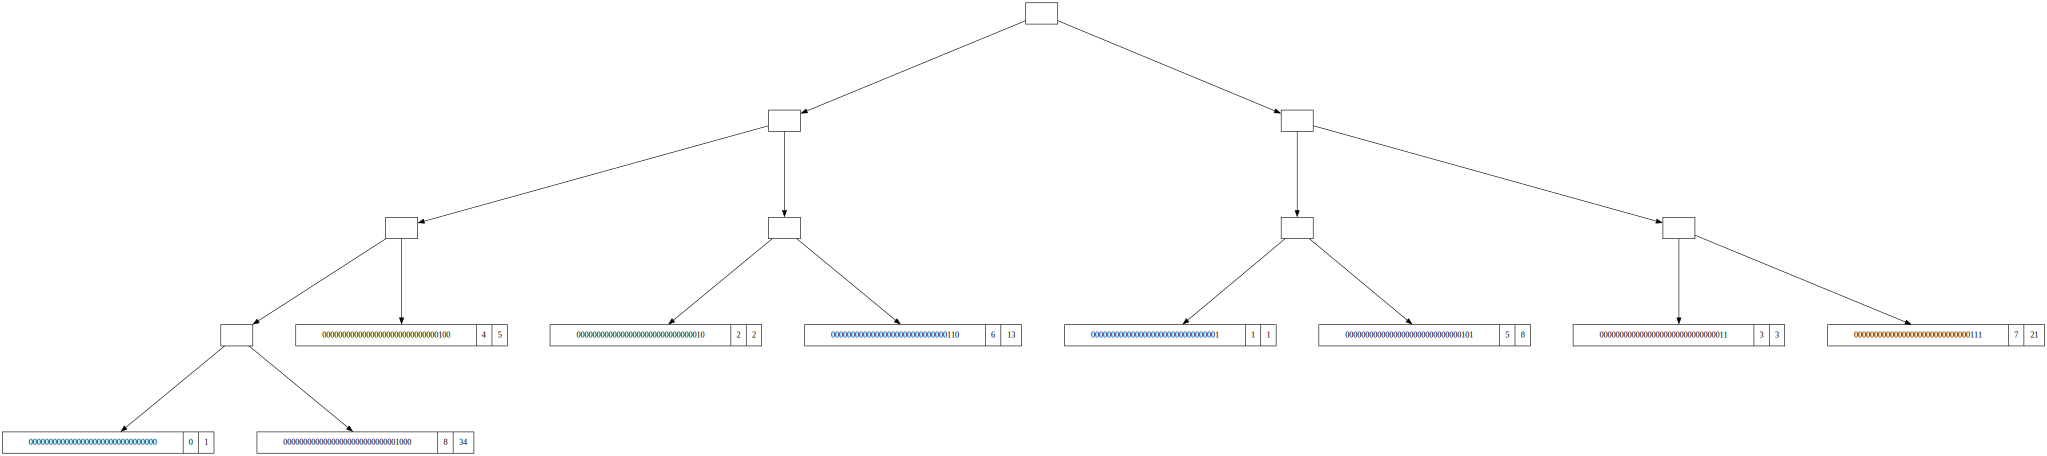

In [15]:
dot $ dotFromHBMT $ snd $ fib' emptyHashBinaryMappedTrie 8

</details>

</div>
</details>

As we can see, this data structure does actually work, and if that's all we require, we could probably stop here. However, the most obvious issue is that the low branching factor of 2 means that our trees get too deep too quickly and that negatively impacts the time and space complexity of most operations. We will address this shortly, but first I would like to take a slight detour and do some [prefactoring](https://martinfowler.com/articles/preparatory-refactoring-example.html) to make this possible: instead of having child nodes point directly to a parent node, let's store a 2-element array in the parent node and have the children live there.

In [16]:
data Hash2ArrayMappedTrie key value
    = Hash2ArrayMappedTrieNone
    | Hash2ArrayMappedTrieLeaf Hash key value
    | Hash2ArrayMappedTrieNode (Vector (Hash2ArrayMappedTrie key value))
    deriving (Eq, Show)

We can reuse most of our existing code with only minor changes to account for the existence of the array, which will always have two elements.

In [17]:
insertHash2ArrayMappedTrie :: (Hashable key) => key -> value -> Hash2ArrayMappedTrie key value -> Hash2ArrayMappedTrie key value
insertHash2ArrayMappedTrie key = insertHash2ArrayMappedTrieHelper 0 (hash key) key

insertHash2ArrayMappedTrieHelper :: Int -> Hash -> key -> value -> Hash2ArrayMappedTrie key value -> Hash2ArrayMappedTrie key value
insertHash2ArrayMappedTrieHelper depth hash key value Hash2ArrayMappedTrieNone =
    Hash2ArrayMappedTrieLeaf hash key value
insertHash2ArrayMappedTrieHelper depth hash key value (Hash2ArrayMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = Hash2ArrayMappedTrieLeaf hash key value
    | otherwise = let
        emptyNode = Hash2ArrayMappedTrieNode (replicate 2 Hash2ArrayMappedTrieNone)
        leafInsertedNode = insertHash2ArrayMappedTrieHelper depth leafHash leafKey leafValue emptyNode
        in insertHash2ArrayMappedTrieHelper depth hash key value leafInsertedNode
insertHash2ArrayMappedTrieHelper depth hash key value (Hash2ArrayMappedTrieNode children) = let
    goRight = testBit hash depth
    depth' = depth + 1
    in if goRight
        then Hash2ArrayMappedTrieNode $ children // [(1, insertHash2ArrayMappedTrieHelper depth' hash key value (children ! 1))]
        else Hash2ArrayMappedTrieNode $ children // [(0, insertHash2ArrayMappedTrieHelper depth' hash key value (children ! 0))]

In [18]:
lookupHash2ArrayMappedTrie :: (Hashable key) => key -> Hash2ArrayMappedTrie key value -> Maybe value
lookupHash2ArrayMappedTrie key = lookupHash2ArrayMappedTrieHelper 0 (hash key) key

lookupHash2ArrayMappedTrieHelper :: Int -> Hash -> key -> Hash2ArrayMappedTrie key value -> Maybe value
lookupHash2ArrayMappedTrieHelper depth hash key Hash2ArrayMappedTrieNone = Nothing
lookupHash2ArrayMappedTrieHelper depth hash key (Hash2ArrayMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = Just leafValue
    | otherwise = Nothing
lookupHash2ArrayMappedTrieHelper depth hash key (Hash2ArrayMappedTrieNode children) = let
    goRight = testBit hash depth
    depth' = depth + 1
    in if goRight
        then lookupHash2ArrayMappedTrieHelper depth' hash key (children ! 1)
        else lookupHash2ArrayMappedTrieHelper depth' hash key (children ! 0)

In [19]:
emptyHash2ArrayMappedTrie = Hash2ArrayMappedTrieNone

In [20]:
instance Mapping Hash2ArrayMappedTrie where
    empty = emptyHash2ArrayMappedTrie
    insert = insertHash2ArrayMappedTrie
    lookup = lookupHash2ArrayMappedTrie

And as before we can define a function to render this tree using Graphviz:
<details>
    <summary>Hash 2-Array Mapped Trie</summary>

In [21]:
data Hash2ArrayMappedTrieGraphvizNode
    = Hash2ArrayMappedTrieGraphvizNode
        { hash2ArrayMappedTrieGraphvizNodeId :: Int
        , hash2ArrayMappedTrieGraphvizFields :: [Int]
        }
    | Hash2ArrayMappedTrieGraphvizLeafNode
        { hash2ArrayMappedTrieGraphvizLeafNodeId :: Int
        , hash2ArrayMappedTrieGraphvizLeafHash :: String
        , hash2ArrayMappedTrieGraphvizLeafKey :: String
        , hash2ArrayMappedTrieGraphvizLeafNodeValue :: String
        }
    deriving (Eq, Show)

numberH2AMT :: (Show k, Show v) => Hash2ArrayMappedTrie k v -> WriterT [Hash2ArrayMappedTrieGraphvizNode] (State Int) Int
numberH2AMT Hash2ArrayMappedTrieNone = do
    tell mempty
    pure 0
numberH2AMT (Hash2ArrayMappedTrieLeaf h k v) = do
    i <- lift getFreshId
    tell [Hash2ArrayMappedTrieGraphvizLeafNode i (show h) (show k) (show v)]
    pure i
numberH2AMT (Hash2ArrayMappedTrieNode hs) = do
    i <- lift getFreshId
    numbered <- Vector.toList <$> traverse numberH2AMT hs
    tell [Hash2ArrayMappedTrieGraphvizNode i numbered]
    pure i

nodeLinesH2AMT :: Hash2ArrayMappedTrieGraphvizNode -> [String]
nodeLinesH2AMT (Hash2ArrayMappedTrieGraphvizLeafNode i h k v) = let
    label = intercalate "|" [h, k, v]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in [line]
nodeLinesH2AMT (Hash2ArrayMappedTrieGraphvizNode i fs) = let
    indices = Prelude.take (length fs) [0..]
    pairs = zip indices fs
    edges = flip map pairs $ \(f,t) -> "n" ++ show i ++ ":" ++ "f" ++ show f ++ " -> " ++ "n" ++ show t
    fields = flip map indices $ \ix -> "<f" ++ show ix ++ ">"
    label = intercalate "|" fields
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in (line:edges)

dotFromH2AMT :: (Show k, Show v) => Hash2ArrayMappedTrie k v -> String
dotFromH2AMT = makeDot . makeDotLines. concatMap nodeLinesH2AMT . flip evalState 0 . execWriterT . numberH2AMT

</details>

The corresponding tree created by `fib' 8` looks very similar:
<details>
    <summary>Hash 2-Array Mapped Trie</summary>
    <div style="overflow: scroll">

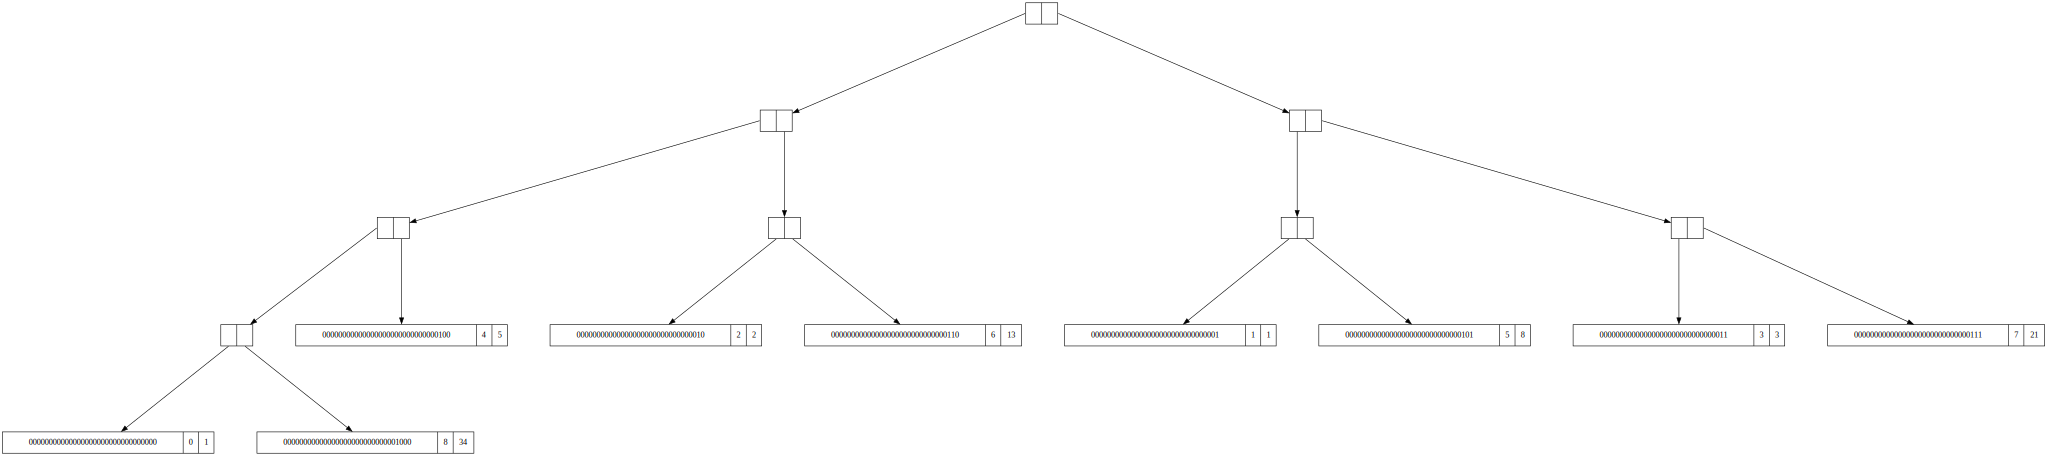

In [22]:
dot $ dotFromH2AMT $ snd $ fib' emptyHash2ArrayMappedTrie 8

</div>
</details>

Now that we're using arrays, we can fix our branching factor problem by recognising the relationship between the number of bits of the hash that we are plucking off and inspecting at each level and the children each node can have. So far we have only been inspecting one bit, which can have two values and therefore two children. If we were to inspect two bits at each level, we could have four possible children per fragment (corresponding to the values 00, 01, 10, and 11), 8 children for 3 bits, and so on. I've chosen to use 4 bits which means 16 children.

I'm going to call this iteration `HashArrayMappedTrieSpacious` because it's space-inefficient in a way we'll discuss and fix later.

In [23]:
data HashArrayMappedTrieSpacious key value
    = HashArrayMappedTrieSpaciousNone
    | HashArrayMappedTrieSpaciousLeaf Hash key value
    | HashArrayMappedTrieSpaciousNode (Vector (HashArrayMappedTrieSpacious key value))
    deriving (Eq, Show)

An important point is that we re-interpret the hash fragment as the index into our array, e.g. `0110` is the 6th index. We'll need some bit-twiddling functions to make this easier.

In [24]:
hashFragmentLength :: Int
hashFragmentLength = 4

hashMask = bit hashFragmentLength - 1 -- 0b1111

To `insert` and `lookup` elements, we now need to:

1. Mask off the correct 4 bits of the hash.
2. Interpret the 4-bit hash fragment as an index from 0 to 15.
3. Insert/lookup the element at the corresponding index of the array, recursively creating it if required.

In [25]:
insertHashArrayMappedTrieSpacious :: (Hashable key) => key -> value -> HashArrayMappedTrieSpacious key value -> HashArrayMappedTrieSpacious key value
insertHashArrayMappedTrieSpacious key = insertHashArrayMappedTrieSpaciousHelper 0 (hash key) key

insertHashArrayMappedTrieSpaciousHelper :: Int -> Hash -> key -> value -> HashArrayMappedTrieSpacious key value -> HashArrayMappedTrieSpacious key value
insertHashArrayMappedTrieSpaciousHelper depth hash key value HashArrayMappedTrieSpaciousNone =
    HashArrayMappedTrieSpaciousLeaf hash key value
insertHashArrayMappedTrieSpaciousHelper depth hash key value (HashArrayMappedTrieSpaciousLeaf leafHash leafKey leafValue)
    | hash == leafHash = HashArrayMappedTrieSpaciousLeaf hash key value
    | otherwise = let
        emptyNode = HashArrayMappedTrieSpaciousNode (replicate (2^hashFragmentLength) HashArrayMappedTrieSpaciousNone)
        leafInsertedNode = insertHashArrayMappedTrieSpaciousHelper depth leafHash leafKey leafValue emptyNode
        in insertHashArrayMappedTrieSpaciousHelper depth hash key value leafInsertedNode
insertHashArrayMappedTrieSpaciousHelper depth hash key value (HashArrayMappedTrieSpaciousNode children) = let
    hashFragment = (hash `shiftR` depth) .&. hashMask
    index = fromIntegral hashFragment
    depth' = depth + hashFragmentLength
    in HashArrayMappedTrieSpaciousNode
        (children // [(index, insertHashArrayMappedTrieSpaciousHelper depth' hash key value (children ! index))])

In [26]:
lookupHashArrayMappedTrieSpacious :: (Hashable key) => key -> HashArrayMappedTrieSpacious key value -> Maybe value
lookupHashArrayMappedTrieSpacious key = lookupHashArrayMappedTrieSpaciousHelper 0 (hash key) key

lookupHashArrayMappedTrieSpaciousHelper :: Int -> Hash -> key -> HashArrayMappedTrieSpacious key value -> Maybe value
lookupHashArrayMappedTrieSpaciousHelper depth hash key HashArrayMappedTrieSpaciousNone = Nothing
lookupHashArrayMappedTrieSpaciousHelper depth hash key (HashArrayMappedTrieSpaciousLeaf leafHash leafKey leafValue)
    | hash == leafHash = Just leafValue
    | otherwise = Nothing
lookupHashArrayMappedTrieSpaciousHelper depth hash key (HashArrayMappedTrieSpaciousNode children) = let
    hashFragment = (hash `shiftR` depth) .&. hashMask
    index = fromIntegral hashFragment
    depth' = depth + hashFragmentLength
    in lookupHashArrayMappedTrieSpaciousHelper depth' hash key (children ! index)

In [27]:
emptyHashArrayMappedTrieSpacious = HashArrayMappedTrieSpaciousNone

In [28]:
instance Mapping HashArrayMappedTrieSpacious where
    empty = emptyHashArrayMappedTrieSpacious
    insert = insertHashArrayMappedTrieSpacious
    lookup = lookupHashArrayMappedTrieSpacious

Once again we can define a rendering function:

<details>
    <summary>Hash Array Mapped Trie (Spacious)</summary>

In [29]:
data HashArrayMappedTrieSpaciousGraphvizNode
    = HashArrayMappedTrieSpaciousGraphvizNode
        { hashArrayMappedTrieSpaciousGraphvizNodeId :: Int
        , hashArrayMappedTrieSpaciousGraphvizFields :: [Int]
        }
    | HashArrayMappedTrieSpaciousGraphvizLeafNode
        { hashArrayMappedTrieSpaciousGraphvizLeafNodeId :: Int
        , hashArrayMappedTrieSpaciousGraphvizLeafHash :: String
        , hashArrayMappedTrieSpaciousGraphvizLeafKey :: String
        , hashArrayMappedTrieSpaciousGraphvizLeafNodeValue :: String
        }
    deriving (Eq, Show)

numberHAMTS :: (Show k, Show v) => HashArrayMappedTrieSpacious k v -> WriterT [HashArrayMappedTrieSpaciousGraphvizNode] (State Int) Int
numberHAMTS HashArrayMappedTrieSpaciousNone = do
    tell mempty
    pure 0
numberHAMTS (HashArrayMappedTrieSpaciousLeaf h k v) = do
    i <- lift getFreshId
    tell [HashArrayMappedTrieSpaciousGraphvizLeafNode i (show h) (show k) (show v)]
    pure i
numberHAMTS (HashArrayMappedTrieSpaciousNode hs) = do
    i <- lift getFreshId
    numbered <- Vector.toList <$> traverse numberHAMTS hs
    tell [HashArrayMappedTrieSpaciousGraphvizNode i numbered]
    pure i

nodeLinesHAMTS :: HashArrayMappedTrieSpaciousGraphvizNode -> [String]
nodeLinesHAMTS (HashArrayMappedTrieSpaciousGraphvizLeafNode i h k v) = let
    label = intercalate "|" [h, k, v]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in [line]
nodeLinesHAMTS (HashArrayMappedTrieSpaciousGraphvizNode i fs) = let
    indices = Prelude.take (length fs) [0..]
    pairs = filter (\(_,i) -> i /= 0) $ zip indices fs
    edges = flip map pairs $ \(f,t) -> "n" ++ show i ++ ":" ++ "f" ++ show f ++ " -> " ++ "n" ++ show t
    fields = flip map indices $ \ix -> "<f" ++ show ix ++ ">"
    label = intercalate "|" fields
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in (line:edges)

dotFromHAMTS :: (Show k, Show v) => HashArrayMappedTrieSpacious k v -> String
dotFromHAMTS = makeDot . makeDotLines. concatMap nodeLinesHAMTS . flip evalState 0 . execWriterT . numberHAMTS

</details>

And inspect our handiwork:
<details>
    <summary>Hash Array Mapped Trie (Spacious)</summary>
    <div style="overflow: scroll">

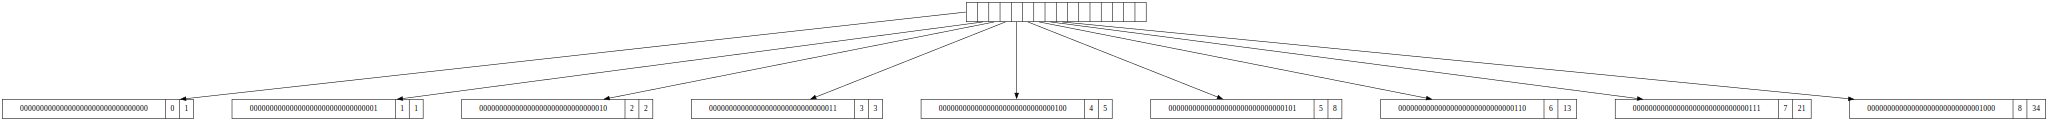

In [30]:
dot $ dotFromHAMTS $ snd $ fib' emptyHashArrayMappedTrieSpacious 8

</div>
</details>

This is much better from a time-complexity perspective because the branching factor is higher. However, there's one new issue we have introduced: it might not be so obvious in our small 8-element tree above, but every parent node now stores a 16-element array regardless of how many children it has. This is unnecessarily wasteful, and we can improve here.

Ideally we'd want to store an array that's just big enough to fit the correct number of children, which we would resize as necessary when inserting or deleting elements. To accomplish this, we'll paradoxically need to store another mapping between hash fragments and array indices. We'll of course want this mapping to have minimal overhead, otherwise it wouldn't end up saving much (or any) space.

This impressive technical feat is made possible by the magic of bitmaps! The general idea is that we store an additional bitmap that is the same size as the maximum length of the array (16 in our case), and then we do some more bit-twiddling that uses a hash fragment together with this bitmap to determine the correct index. The algorithm is:

1. Interpret the hash fragment as a number `n`.
2. If inserting, set the `n`th bit of the bitmap.
3. Mask off all bits `n` and above in the bitmap.
4. The [population count](https://vaibhavsagar.com/blog/2019/09/08/popcount/#hash-array-mapped-tries) of the remaining bits is the index.

Let's try an example. We start with an empty bitmap:

```
┌───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┐
│ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
└───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┘
  6   5   4   3   2   1   0   9   8   7   6   5   4   3   2   1   0
  1   1   1   1   1   1   1
```

And we want to insert an element `x` with a hash fragment of `0b0100`. This is interpreted as `4`, so we set that in the bitmap:

```
┌───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┐
│ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │
└───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┘
  6   5   4   3   2   1   0   9   8   7   6   5   4   3   2   1   0
  1   1   1   1   1   1   1
```

Then we mask off all bits `4` and above:

```
┌───┬───┬───┬───┐
│ 0 │ 0 │ 0 │ 0 │
└───┴───┴───┴───┘
  3   2   1   0
```

And the population count of this bitmap is `0`, which is our index.

The array looks like this:

```
┌───┐
│ x │
└───┘
  0
```

Let's now insert an element `y` with a hash fragment of `0b1010`. This is interpreted as `9`, so we set that:

```
┌───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┐
│ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │
└───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┘
  6   5   4   3   2   1   0   9   8   7   6   5   4   3   2   1   0
  1   1   1   1   1   1   1
```

Mask off all bits `9` and above:

```
┌───┬───┬───┬───┬───┬───┬───┬───┬───┐
│ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │
└───┴───┴───┴───┴───┴───┴───┴───┴───┘
  8   7   6   5   4   3   2   1   0
```

And the population count of this bitmap is `1`, which is our index.

The array now looks like this:

```
┌───┬───┐
│ x │ y │
└───┴───┘
  0   1
```

Finally, let's insert an element `z` with a hash fragment of `0b0010`, or `2`:

```
┌───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┐
│ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │ 1 │ 0 │ 0 │
└───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┴───┘
  6   5   4   3   2   1   0   9   8   7   6   5   4   3   2   1   0
  1   1   1   1   1   1   1
```

We mask off bits `2` and above:

```
┌───┬───┐
│ 0 │ 0 │
└───┴───┘
  1   0
```

The population count of this bitmap is also `0`, which means we need to insert this new element at the beginning of the array and shift the other elements to the right:

```
┌───┬───┬───┐
│ z │ x │ y │
└───┴───┴───┘
  0   1   2
```

The updated bitmap means that looking up our other elements will still work correctly.

With that taken care of, we arrive at our final data structure:

In [31]:
data HashArrayMappedTrie key value
    = HashArrayMappedTrieNone
    | HashArrayMappedTrieLeaf Hash key value
    | HashArrayMappedTrieNode (Binary Word16) (Vector (HashArrayMappedTrie key value))
    deriving (Eq, Show)

We modify our `insert` and `lookup` functions to use bitmaps as described above:

In [32]:
insertHashArrayMappedTrie :: (Hashable key) => key -> value -> HashArrayMappedTrie key value -> HashArrayMappedTrie key value
insertHashArrayMappedTrie key = insertHashArrayMappedTrieHelper 0 (hash key) key

insertHashArrayMappedTrieHelper :: Int -> Hash -> key -> value -> HashArrayMappedTrie key value -> HashArrayMappedTrie key value
insertHashArrayMappedTrieHelper depth hash key value HashArrayMappedTrieNone =
    HashArrayMappedTrieLeaf hash key value
insertHashArrayMappedTrieHelper depth hash key value leaf@(HashArrayMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = HashArrayMappedTrieLeaf hash key value
    | otherwise = let
        leafHashFragment = (leafHash `shiftR` depth) .&. hashMask
        leafBitmap = bit (fromIntegral leafHashFragment)
        leafInsertedNode = HashArrayMappedTrieNode leafBitmap (singleton leaf)
        in insertHashArrayMappedTrieHelper depth hash key value leafInsertedNode
insertHashArrayMappedTrieHelper depth hash key value (HashArrayMappedTrieNode bitmap children) = let
    hashFragment = (hash `shiftR` depth) .&. hashMask
    elemBitmap = bit (fromIntegral hashFragment)
    index = popCount (bitmap .&. (elemBitmap - 1))
    depth' = depth + hashFragmentLength
    in if elemBitmap .&. bitmap == 0
        then let
            leaf = HashArrayMappedTrieLeaf hash key value
            bitmap' = bitmap .|. elemBitmap
            children' = take index children <> singleton leaf <> drop index children
            in HashArrayMappedTrieNode bitmap' children'
        else let
            subtree = children ! index
            subtree' = insertHashArrayMappedTrieHelper depth' hash key value subtree
            children' = children // [(index, subtree')]
            in HashArrayMappedTrieNode bitmap children'

In [33]:
lookupHashArrayMappedTrie :: (Hashable key) => key -> HashArrayMappedTrie key value -> Maybe value
lookupHashArrayMappedTrie key = lookupHashArrayMappedTrieHelper 0 (hash key) key

lookupHashArrayMappedTrieHelper :: Int -> Hash -> key -> HashArrayMappedTrie key value -> Maybe value
lookupHashArrayMappedTrieHelper depth hash key HashArrayMappedTrieNone = Nothing
lookupHashArrayMappedTrieHelper depth hash key (HashArrayMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = Just leafValue
    | otherwise = Nothing
lookupHashArrayMappedTrieHelper depth hash key (HashArrayMappedTrieNode bitmap children) = let
    hashFragment = (hash `shiftR` depth) .&. hashMask
    elemBitmap = bit (fromIntegral hashFragment)
    index = popCount (bitmap .&. (elemBitmap - 1))
    depth' = depth + hashFragmentLength
    in if elemBitmap .&. bitmap == 0
        then Nothing
        else lookupHashArrayMappedTrieHelper depth' hash key (children ! index)

In [34]:
emptyHashArrayMappedTrie = HashArrayMappedTrieNone

In [ ]:
instance Mapping HashArrayMappedTrie where
    empty = emptyHashArrayMappedTrie
    insert = insertHashArrayMappedTrie
    lookup = lookupHashArrayMappedTrie

And one last time, we can render these:
<details>
    <summary>Hash Array Mapped Trie</summary>

In [ ]:
data HashArrayMappedTrieGraphvizNode
    = HashArrayMappedTrieGraphvizNode
        { hashArrayMappedTrieGraphvizNodeId :: Int
        , hashArrayMappedTrieGraphvizBitmap :: String
        , hashArrayMappedTrieGraphvizFields :: [Int]
        }
    | HashArrayMappedTrieGraphvizLeafNode
        { hashArrayMappedTrieGraphvizLeafNodeId :: Int
        , hashArrayMappedTrieGraphvizLeafHash :: String
        , hashArrayMappedTrieGraphvizLeafKey :: String
        , hashArrayMappedTrieGraphvizLeafNodeValue :: String
        }
    deriving (Eq, Show)

numberHAMT :: (Show k, Show v) => HashArrayMappedTrie k v -> WriterT [HashArrayMappedTrieGraphvizNode] (State Int) Int
numberHAMT HashArrayMappedTrieNone = do
    tell mempty
    pure 0
numberHAMT (HashArrayMappedTrieLeaf h k v) = do
    i <- lift getFreshId
    tell [HashArrayMappedTrieGraphvizLeafNode i (show h) (show k) (show v)]
    pure i
numberHAMT (HashArrayMappedTrieNode b hs) = do
    i <- lift getFreshId
    numbered <- Vector.toList <$> traverse numberHAMT hs
    tell [HashArrayMappedTrieGraphvizNode i (show b) numbered]
    pure i

nodeLinesHAMT :: HashArrayMappedTrieGraphvizNode -> [String]
nodeLinesHAMT (HashArrayMappedTrieGraphvizLeafNode i h k v) = let
    label = intercalate "|" [h, k, v]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in [line]
nodeLinesHAMT (HashArrayMappedTrieGraphvizNode i b fs) = let
    indices = Prelude.take (length fs) [0..]
    pairs = zip indices fs
    edges = flip map pairs $ \(f,t) -> "n" ++ show i ++ ":" ++ "f" ++ show f ++ " -> " ++ "n" ++ show t
    fields = flip map indices $ \ix -> "<f" ++ show ix ++ ">"
    label = intercalate "|" $ b:fields
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in (line:edges)

dotFromHAMT :: (Show k, Show v) => HashArrayMappedTrie k v -> String
dotFromHAMT = makeDot . makeDotLines. concatMap nodeLinesHAMT . flip evalState 0 . execWriterT . numberHAMT

</div>
</details>

<details>
    <summary>Hash Array Mapped Trie</summary>
    <div style="overflow: scroll">

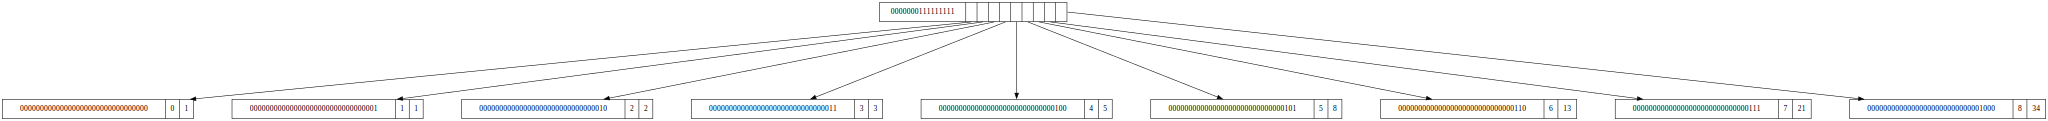

In [ ]:
dot $ dotFromHAMT $ snd $ fib' emptyHashArrayMappedTrie 8

</div>
</details>

And we're done! Here are a few more things to explore that I didn't have space to cover here:

- These data structures don't handle collisions, but these could be added with a `Collision` node that stores a list of key-value pairs where the keys all share the same hash.

- In the case where a node's bitmap is full, we don't need to do most of the bit-twiddling above, and in practice most implementations also have a special `Full` node for this purpose.

- I've only looked at `insert` and `lookup`, but there are some intricacies to implementing `delete` etc.

- All these data structures are persistent, by virtue of them being implemented with immutable vectors. The original paper uses mutable vectors and is not persistent.

- Even in the case where we want a persistent data structure, we might want to do a series of updates to a "thawed" version of the structure and then "freeze" it afterwards like we do with vectors in Haskell. I don't know of an implementation that has this capability.